In [1]:
import os
import pandas as pd
import fuzzymatcher
from mplsoccer.pitch import Pitch
import numpy as np

Load the data

In [2]:
STATSBOMB_SHOTS = os.path.join('..', '..', 'data', 'statsbomb', 'shots.parquet')
WYSCOUT_SHOTS = os.path.join('..', '..', 'data', 'wyscout', 'shots.parquet')
FREEZE_FEATURES = os.path.join('..', '..', 'data', 'statsbomb', 'freeze_features.parquet')
df_statsbomb_shots = pd.read_parquet(STATSBOMB_SHOTS)
df_wyscout_shots = pd.read_parquet(WYSCOUT_SHOTS)
df_freeze_frame = pd.read_parquet(FREEZE_FEATURES)

Remove three shots without player info

In [3]:
df_wyscout_shots = df_wyscout_shots[df_wyscout_shots.player_id.notnull()].copy()

Get a unique team id by combining the datasets and using a fuzzy match on team name

In [4]:
cols = ['team_id', 'team_name', 'competition_gender']
a = df_wyscout_shots[cols].drop_duplicates('team_id', keep='last').rename({'team_id': 'wyscout_team_id'}, axis=1).copy()
b = df_statsbomb_shots[cols].drop_duplicates('team_id', keep='last').rename({'team_id': 'statsbomb_team_id'}, axis=1).copy()
team_match = fuzzymatcher.fuzzy_left_join(a,
                                          b,
                                          left_on=['team_name', 'competition_gender'],
                                          right_on=['team_name', 'competition_gender'],
                                          left_id_col='wyscout_team_id',
                                          right_id_col='statsbomb_team_id')
team_match = team_match[(team_match.best_match_score > 0.02) & (team_match.competition_gender_right == 'male')].copy()
team_match = (team_match[['wyscout_team_id', 'statsbomb_team_id', 'competition_gender_right', 'team_name_right']]
              .rename({'team_name_right': 'team_name', 'competition_gender_right': 'competition_gender'}, axis=1)
              .copy())
df_team = pd.concat([a[~a.wyscout_team_id.isin(team_match.wyscout_team_id)],
                     b[~b.statsbomb_team_id.isin(team_match.statsbomb_team_id)],
                     team_match])
df_team.reset_index(drop=True, inplace=True)
df_team.index.name = 'team_id'
df_team.reset_index(inplace=True)

Add the unique team_id/ name to the datasets

In [5]:
# wyscout
a = df_team[['team_id', 'wyscout_team_id', 'team_name']].copy()
df_wyscout_shots.rename({'team_id': 'wyscout_team_id'}, axis=1, inplace=True)
df_wyscout_shots.drop('team_name', axis=1, inplace=True)
df_wyscout_shots = df_wyscout_shots.merge(a, how='left', on='wyscout_team_id')
# statsbomb
b = df_team[['team_id', 'statsbomb_team_id', 'team_name']].copy()
df_statsbomb_shots.rename({'team_id': 'statsbomb_team_id'}, axis=1, inplace=True)
df_statsbomb_shots.drop('team_name', axis=1, inplace=True)
df_statsbomb_shots = df_statsbomb_shots.merge(b, how='left', on='statsbomb_team_id')

Get a unique player id

In [6]:
# get a dataframe of statsbomb players
cols = ['player_id', 'team_id', 'team_name', 'firstName', 'middleName', 'lastName', 'Name', 'competition_gender']
statsbomb_players = df_statsbomb_shots[cols].drop_duplicates('player_id').copy()
statsbomb_players.rename({'player_id': 'player_id_statsbomb'}, axis=1, inplace=True)
# get a dataframe of wyscout players
wyscout_players = df_wyscout_shots[cols].drop_duplicates('player_id').copy()
wyscout_players.rename({'player_id': 'player_id_wyscout'}, axis=1, inplace=True)

In [7]:
# merge the two datasets: exact match on names
exact_match = wyscout_players.merge(statsbomb_players, how='inner', 
                                    on=['firstName', 'middleName', 'lastName', 'Name'],
                                    suffixes=['_wyscout', '_statsbomb'])
print('Check no duplicates:', exact_match.player_id_wyscout.duplicated().sum(), 
      exact_match.player_id_statsbomb.duplicated().sum())
exact_match = exact_match[['player_id_wyscout', 'player_id_statsbomb', 'firstName', 'middleName', 'lastName', 'Name']].copy()

Check no duplicates: 0 0


In [8]:
# for the unmatched use a fuzzy match to match on names
not_matched_statsbomb = statsbomb_players[~statsbomb_players.player_id_statsbomb.isin(exact_match.player_id_statsbomb)].copy()
not_matched_wyscout = wyscout_players[~wyscout_players.player_id_wyscout.isin(exact_match.player_id_wyscout)].copy()
fuzzy_match = fuzzymatcher.fuzzy_left_join(not_matched_wyscout,
                                           not_matched_statsbomb,
                                           left_on=['Name'],
                                           right_on=['Name'],
                                           left_id_col='player_id_wyscout',
                                           right_id_col='player_id_statsbomb')
fuzzy_match.sort_values('best_match_score', ascending=False, inplace=True)
fuzzy_match.drop_duplicates('player_id_wyscout', keep='first', inplace=True)
fuzzy_match.drop_duplicates('player_id_statsbomb', keep='first', inplace=True)
# drop some dodgy matches just above the threshold (hand checked)
fuzzy_match = fuzzy_match[(fuzzy_match.best_match_score > 0.25)  & 
                          (fuzzy_match.competition_gender_left == fuzzy_match.competition_gender_right) & 
                          (~fuzzy_match.player_id_statsbomb.isin([23804, 40366, 40257]))].copy()

In [9]:
# concatenate all the matches
fuzzy_match = fuzzy_match[['player_id_wyscout', 'player_id_statsbomb', 'firstName_right',
                           'middleName_right', 'lastName_right', 'Name_right']].copy()
fuzzy_match.rename({'firstName_right': 'firstName', 'middleName_right': 'middleName',
                    'lastName_right': 'lastName', 'Name_right': 'Name'}, axis=1, inplace=True)
matches = pd.concat([fuzzy_match, exact_match])
# add the non-matches
not_matched_wyscout = wyscout_players[~wyscout_players.player_id_wyscout.isin(matches.player_id_wyscout)].copy()
not_matched_statsbomb = statsbomb_players[~statsbomb_players.player_id_statsbomb.isin(matches.player_id_statsbomb)].copy()
all_players = pd.concat([matches, not_matched_wyscout, not_matched_statsbomb])
all_players.drop(['team_id', 'team_name', 'competition_gender'], axis=1, inplace=True)
all_players.reset_index(drop=True, inplace=True)
all_players.index.name = 'player_id'
all_players.reset_index(inplace=True)

Add unique player id/ Names to datasets

In [10]:
# merge statsbomb
df_statsbomb_shots.drop(['firstName', 'middleName', 'lastName', 'Name'], axis=1, inplace=True)
df_statsbomb_shots.rename({'player_id': 'player_id_statsbomb'}, axis=1, inplace=True)
df_statsbomb_shots = df_statsbomb_shots.merge(all_players.drop('player_id_wyscout', axis=1),
                                              on='player_id_statsbomb', how='left')
# merge wyscout
df_wyscout_shots.drop(['firstName', 'middleName', 'lastName', 'Name'], axis=1, inplace=True)
df_wyscout_shots.rename({'player_id': 'player_id_wyscout'}, axis=1, inplace=True)
df_wyscout_shots = df_wyscout_shots.merge(all_players.drop('player_id_statsbomb', axis=1),
                                          on='player_id_wyscout', how='left')

Merge freeze frame features

In [11]:
df_statsbomb_shots = df_statsbomb_shots.merge(df_freeze_frame, on='id', how='left')

Concatenate shot datasets

In [12]:
df_statsbomb_shots['dataset'] = 'statsbomb'
df_wyscout_shots.rename({'id': 'wyscout_id'}, axis=1, inplace=True)
df_wyscout_shots['dataset'] = 'wyscout'
df_statsbomb_shots.rename({'id': 'statsbomb_id'}, axis=1, inplace=True)
df_all_shots = pd.concat([df_statsbomb_shots, df_wyscout_shots], axis=0)

Pass technique name to 'other' if null

In [13]:
df_all_shots.loc[(df_all_shots.pass_technique_name.isnull()) &
                 (df_all_shots.assist_type == 'pass'), 'pass_technique_name'] = 'other'

Save dataset

In [14]:
df_all_shots.reset_index(drop=True, inplace=True)

In [15]:
df_all_shots.to_parquet(os.path.join('..', '..', 'data', 'shots.parquet'))

Info

In [16]:
df_all_shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64396 entries, 0 to 64395
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   match_id                64396 non-null  int64  
 1   statsbomb_id            21532 non-null  object 
 2   goal                    64396 non-null  bool   
 3   statsbomb_team_id       21532 non-null  float64
 4   player_id_statsbomb     21532 non-null  float64
 5   shot_type_name          64396 non-null  object 
 6   x                       64396 non-null  float64
 7   y                       64396 non-null  float64
 8   counter_attack          64396 non-null  bool   
 9   fast_break              64396 non-null  bool   
 10  strong_foot             64396 non-null  bool   
 11  body_part_name          64396 non-null  object 
 12  assist_type             64396 non-null  object 
 13  pass_end_y              15291 non-null  float64
 14  pass_end_x              15291 non-null

Compare datasets

Text(0.5, 1.0, 'Wyscout')

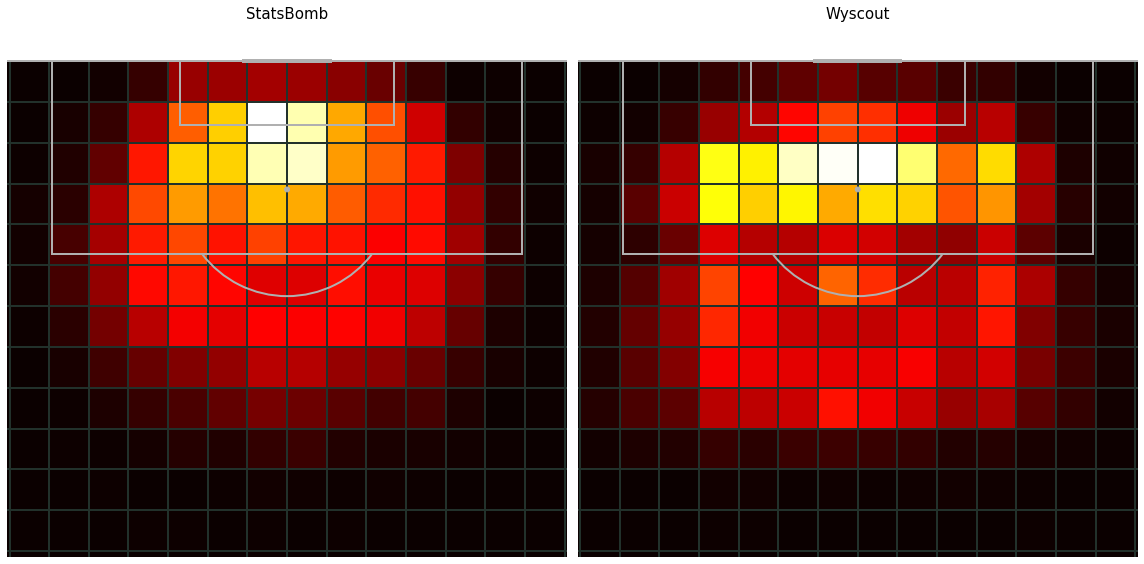

In [17]:
pitch = Pitch(pitch_type='statsperform', figsize=(16, 12), layout=(1, 2), pad_left=-10, pad_right=-10, pad_bottom=-10,
              orientation='vertical', view='half', line_zorder=2)
fig, ax = pitch.draw()
ax = ax.ravel()
bs = pitch.bin_statistic(df_all_shots[df_all_shots.dataset=='statsbomb'].x,
                         df_all_shots[df_all_shots.dataset=='statsbomb'].y, 
                         statistic='count', bins=(30, 20))
bs['statistic'] = (bs['statistic']).astype(np.int32)
pcm = pitch.heatmap(bs, ax=ax[0], cmap='hot', edgecolors='#22312b')
ax[0].set_title('StatsBomb', fontsize=15, pad=-4)
bs = pitch.bin_statistic(df_all_shots[df_all_shots.dataset=='wyscout'].x,
                         df_all_shots[df_all_shots.dataset=='wyscout'].y,
                         statistic='count', bins=(30, 20))
bs['statistic'] = (bs['statistic']).astype(np.int32)
pcm = pitch.heatmap(bs, ax=ax[1], cmap='hot', edgecolors='#22312b')
ax[1].set_title('Wyscout', fontsize=15, pad=-4)

In [18]:
df_all_shots.groupby('dataset').fast_break.mean()

dataset
statsbomb    0.033439
wyscout      0.042063
Name: fast_break, dtype: float64

In [19]:
df_all_shots.groupby('dataset').counter_attack.mean()

dataset
statsbomb    0.047278
wyscout      0.052398
Name: counter_attack, dtype: float64

In [20]:
df_all_shots.groupby('dataset').visible_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,21532.0,0.467126,0.299570,0.0,0.274155,0.361681,0.564675,3.141593
wyscout,42864.0,0.406009,0.251117,0.0,0.246501,0.318814,0.492907,3.141593


In [21]:
df_all_shots.groupby('dataset').middle_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,21532.0,0.492256,0.328711,0.0,0.223218,0.452154,0.721041,1.570796
wyscout,42864.0,0.480124,0.312013,0.0,0.227296,0.452154,0.691294,1.570796


In [22]:
df_all_shots.groupby('dataset').distance_to_goal.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,21532.0,16.738719,7.780551,0.6,10.6,15.9,22.3,70.8
wyscout,42864.0,19.029785,8.380983,0.7,12.6,17.8,25.6,75.4


In [23]:
df_all_shots.groupby('dataset').distance_visible_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,21532.0,6.097156,1.152958,0.0,5.602725,6.448973,6.956443,9.738937
wyscout,42864.0,6.169209,1.092615,0.0,5.705352,6.505071,6.992008,7.316065


In [24]:
df_all_shots.groupby('dataset').pass_switch.value_counts()

dataset    pass_switch
statsbomb  False          14307
           True             984
wyscout    False          26483
           True            2062
Name: pass_switch, dtype: int64

In [25]:
df_all_shots.groupby('dataset').pass_cut_back.value_counts()

dataset    pass_cut_back
statsbomb  False            14887
           True               404
wyscout    False            27597
           True               948
Name: pass_cut_back, dtype: int64

In [26]:
df_all_shots.groupby('dataset').pass_cross.value_counts()

dataset    pass_cross
statsbomb  False         12360
           True           2931
wyscout    False         21182
           True           7363
Name: pass_cross, dtype: int64